# Modelos de Mezcla de Funciones Gaussianas

### Julián D. Arias Londoño

Profesor Asociado  
Departamento de Ingeniería de Sistemas  
Universidad de Antioquia, Medellín, Colombia  
julian.ariasl@udea.edu.co

Hasta el momento hemos visto que existen dos posibles aproximaciones al problema de clasificación:
<li>Encontrar una función que represente la frontera de separación entre dos clases</li>
<li>Separar las muestras por clases y estimar una función de densidad de probabilidad (fdp) por cada una de ellas</li>

Los modelos pertenecientes a la primera aproximación se conocen como <b>Discriminativos</b>, debido a que para el ajuste de la frontera se utilizan las muestras de las dos clases al mismo tiempo y el criterio de ajuste del modelo está directamente relacionado con disminuir el error de clasificación.

Los modelos pertenecientes a la segunda aproximación se conocen como <b>Generativos</b> debido a que los modelos se enfocan principalmente en estimar correctamente la fdp de las muestras de cada clase (por ejemplo maximizar la verosimilitud de los datos y el modelo) y no necesariamente en minimizar el error de clasificación. Una vez se tiene un modelo de densidad de probabilidad éste se puede usar para "generar" nuevas muestras, es decir se puede muestrear la fdp y obtener muestras de la misma distribución, por esa razón recibe el nombre de generativos.

In [1]:
%matplotlib inline

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import *

Supongamos un problema de clasificación en el cual las muestras se distribuyen de la siguiente manera:

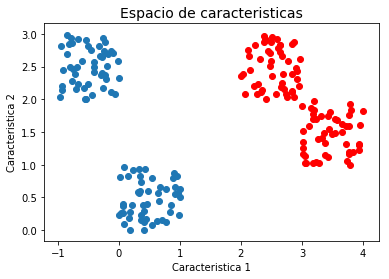

In [3]:
x1 = np.random.rand(2,50)
x2 = np.random.rand(2,50) + 2
x3 = np.random.rand(2,50) + np.tile([[-1],[2]], (1, 50)) #np.tile Es equivalente a repmat en matlab
x4 = np.random.rand(2,50) + np.tile([[3],[1]], (1, 50))
XC1 = np.concatenate((x1,x3),axis=1)
XC2 = np.concatenate((x2,x4),axis=1)
plt.title('Espacio de caracteristicas', fontsize=14)
plt.xlabel('Caracteristica 1')
plt.ylabel('Caracteristica 2')
plt.scatter(XC1[0,:], XC1[1,:])
plt.scatter(XC2[0,:], XC2[1,:],color='red')

In [5]:
import pypr.clustering.gmm as gmm

Si nuestro deseo es usar un clasificador basado en la fdp de cada clase, y por simplicidad decidimos usar un clasificador por función discriminante Gaussiana, es decir, ajustar una función de densidad Gausiana para cada una de las clases, el resultado obtenido sería el siguiente:

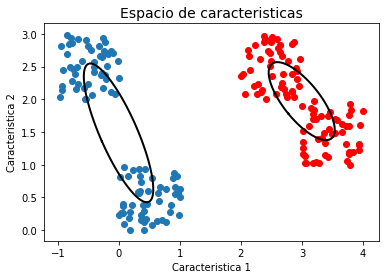

In [6]:
plt.title('Espacio de caracteristicas', fontsize=14)
plt.xlabel('Caracteristica 1')
plt.ylabel('Caracteristica 2')
plt.scatter(XC1[0,:], XC1[1,:])
plt.scatter(XC2[0,:], XC2[1,:],color='red')
C1, C2 = gmm.gauss_ellipse_2d(np.mean(XC1, axis=1), np.cov(XC1))
plot(C1, C2, 'k', linewidth=2)
C1, C2 = gmm.gauss_ellipse_2d(np.mean(XC2, axis=1), np.cov(XC2))
plot(C1, C2, 'k', linewidth=2)

En la figura anterior, cada una de las elipses representa la fdp obtenida para cada una de las clases. El centro de la elipse corresponde a su media y la línea corresponde a dos veces la desviación estándar en cada sentido. Como podemos observar en la figura anterior los modelos se ajustan muy mal debido a que las muestras de cada clase no están agrupadas en un solo conglomerado (cluster). En realidad cada clase está a su vez dividida en varios grupos, y lo que necesitamos es un modelo que pueda representar correctamente esos diferentes grupos.

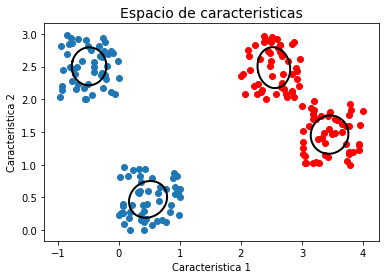

In [7]:
plt.title('Espacio de caracteristicas', fontsize=14)
plt.xlabel('Caracteristica 1')
plt.ylabel('Caracteristica 2')
plt.scatter(XC1[0,:], XC1[1,:])
plt.scatter(XC2[0,:], XC2[1,:],color='red')
C1, C2 = gmm.gauss_ellipse_2d(np.mean(x1, axis=1), np.cov(x1))
plot(C1, C2, 'k', linewidth=2)
C1, C2 = gmm.gauss_ellipse_2d(np.mean(x2, axis=1), np.cov(x2))
plot(C1, C2, 'k', linewidth=2)
C1, C2 = gmm.gauss_ellipse_2d(np.mean(x3, axis=1), np.cov(x3))
plot(C1, C2, 'k', linewidth=2)
C1, C2 = gmm.gauss_ellipse_2d(np.mean(x4, axis=1), np.cov(x4))
plot(C1, C2, 'k', linewidth=2)

Cada conglomerado estaría entonces representado por un vector de medias ${\bf{\mu}}_{ij}$ (clase $i$, conglomerado $j$) y una matriz de covarianza $\Sigma _{ij}$. Sin embargo en este punto surgen varias preguntas que debemos responder:

<li> ¿Qué forma tendría la función de densidad de probabilidad de toda una clase? </li>
<li> ¿En cuántos conglomerados podrían estar agrupadas las muestras? </li>
<li> ¿Cómo determinar cuáles muestras usar para estimar la media y la covarianza del primer conglomerado y cuáles para el segundo? </li>
<li> ¿Cómo se determina el número de conglomerados si no se pueden visualizar las muestras porque el número de características es mayor a 3? </li>

Este tipo de modelos se conocen como <b> Modelos de Mezclas de Funciones Gaussianas</b> (en inglés <b> Gaussian Mixture Models - GMM</b>), y su forma general está dada por la siguiente función:

$$p({\bf{x}}|\Theta_i) = \sum_{j=1}^{M} \omega_{ij} \mathcal{N}({\bf{x}}|\mu_{ij},\Sigma_{ij})$$

In [98]:
def GaussProb(X,medias,covars,pesos):
    M = len(covars)
    N,d = X.shape
    
    Pprob = np.zeros(N).reshape(N,1)
    precision = []
    for i in range(M):
        precision.append(np.linalg.inv(covars[i]))
    
    for j in range(N):
        prob = 0
        for i in range(M):
            tem = (X[j,:]-medias[i])
            tem1 = np.dot(np.dot(tem,precision[i]),tem.T)
            tem2 = 1/((math.pi**(d/2))*(np.linalg.det(covars[i]))**(0.5))
            prob+=pesos[i]*tem2*np.exp(-0.5*tem1)
        Pprob[j] = prob
    return Pprob

donde $M$ es el número de conglomerados en los cuales se van a dividir las muestras, $\omega_{ij}$ son pesos que se le asignan a cada conglomerado, es decir, dan una idea de que tan representativo es el conglomerado dentro de la distribución completa de una clase; deben cumplir la restricción: $\sum_{j=1}^{M} \omega_{ij} = 1$, es decir que la suma de los pesos del modelo GMM para una clase debe ser igual a 1.

El número de conglomerados ($M$) en los cuales se subdivide una clase, es un hiperparámetro del modelo que debe ser ajustado. A partir de las figuras anteriores es fácil determinar que ambas clases están divididas en dos conglomerados, sin embargo, en la gran mayoría de los casos el número de características con las que se cuenta es mucho mayor a 3, razón por la cual no se puede definir el valor de $M$ de manera visual. La forma habitual es utilizar un procedimiento de validación cruzada para hayar el mejor valor de $M$, similar a como debe hacerse para encontrar el mejor valor de $K$ en el modelo de K-vécinos más cercanos.  

El problema de aprendizaje en este caso, corresponde a estimar el conjunto de parámetros $\Theta$ para cada una de las clases, dada un conjunto de muestras de entrenamiento $\mathcal{D} = \left\lbrace  \left( {\bf{x}}_k, y_k \right) \right\rbrace _{k=1} ^{N}$. Del total de muestras de entrenamiento, $N_i$ pertenecen a la clase $i$, es decir $\sum_{i=1}^{\mathcal{C}} N_i = N$, donde $\mathcal{C}$ es el número de clases en el conjunto de muestras de entrenamiento ($y_k$ puede tomar valores $1,2,...,\mathcal{C}$), es decir que el modelo de cada clase se ajusta únicamentente utilizando las $N_i$ muestras pertenecientes a dicha clase.

Como el entrenamiento de un modelo GMM corresponde al ajuste de una fdp, el criterio que nuevamente puede ser de utilidad es el criterio de máxima verosimilitud. Asumiendo entonces que las muestras de entrenamiento de la clase $i$ son i.i.d., podemos expresar el problema de aprendizaje como:

$$\mathop {\max }\limits_\Theta  \log \prod\limits_{k = 1}^{N_i} {p\left( {{\bf{x}}_k |\Theta_i } \right)}$$

reemplazando la forma general del modelo GMM para la clase $i$:

$$ = \mathop {\max }\limits_\Theta  \log \prod\limits_{k = 1}^{N_i} {\sum\limits_{j = 1}^M {w_{ij}{\mathcal N}\left( {{\bf{x}}_k|\mu _{ij} ,\Sigma _{ij} } \right)} }$$

$$= \mathop {\max }\limits_\Theta  \sum\limits_{k = 1}^{N_i} \log {\sum\limits_{j = 1}^M {w_{ij}
{\mathcal N}\left( {{\bf{x}}_k|\mu _{ij} ,\Sigma _{ij} } \right)} }$$

Para encontrar los parámetros que maximizan la función de verosimilitud debemos derivar con respecto a cada uno e igualar a cero. Derivando con respecto a $\mu_{il}$ tenemos:

$$ 0 = - \sum_{k=1}^{N_i} \frac{{w_{il}}\mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})} \Sigma _{il}({\bf{x}}_k- \mu _{il})$$

Si observamos con detenimiento el término

$$\gamma_{kl} = \frac{{w_{il}}\mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})}$$

Mide la probabilidad de que la muestra ${\bf{x}}_k$ sea generada por el conglomerado $l$ dentro de la clase. A $\gamma _{kl}$ también se le conoce como la responsabilidad de la componente $l$ en la "explicación" de la observación de la muestra ${\bf{x}}_k$. 

Reordenando la derivada de la función de verosimilitud que obtuvimos anteriormente, se obtiene:


$$ \hat \mu _{il}  = \frac{1}{n_l} \sum_{k=1}^{N_i} \gamma _{kl} {\bf{x}}_k \;\;\;(*)$$

donde $n_l = \sum_{k=1}^{N_i} \gamma _{kl}$

Teniendo en cuenta que $\gamma _{kl}$ me da una idea del "peso" que tiene la componente $l$ del modelo para generar la muestra $k$, $n_l$ puede entenderse como el peso total de la componente $l$ en el modelo (es una suma para todas las muestras de entrenamiento), o el número total de puntos asignados al conglomerado $l$.

De manera similar se puede derivar con respecto a $\Sigma_{il}$ y obtener:

$$ \hat \Sigma_{il} = \frac{1}{n_l} \sum_{k=1}^{N_i} \gamma _{kl}({\bf{x}}_k - \mu _{il}) ({\bf{x}}_k - \mu _{il})^{T} \;\;\; (* *)$$

que es equivalente a la forma de estimación de la matriz de covarianza en el caso de una sola componente, pero sopesando cada muestra con respecto a la responsabilidad del conglomerado bajo análisis.

Finalmente para la estimación de $w_{ij}$ se hace de manera similar a los dos casos anteriores, pero teniendo en cuenta que los pesos $w$ deben cumplir la restricción estocástica. La función a maximizar en este caso sería:

$$\mathop {\max }\limits_\Theta  \sum\limits_{k = 1}^{N_i} \log {\sum\limits_{j = 1}^M {w_{ij}
{\mathcal N}\left( {{\bf{x}}_k|\mu _{ij} ,\Sigma _{ij} } \right)} } + \lambda \left(\sum _{j=1}^{M} w _{ij} - 1\right)$$

donde $\lambda$ es un multiplicador de Lagrange. Derivando e igualando a cero se obtiene:

$$ 0 = \sum_{k=1}^{N_i} \frac{\mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})}  + \lambda$$

Para poder encontrar el valor de $\lambda$ se puede multiplicar a ambos lados de la ecuación anterior por $w_{il}$ 

$$w_{il}\lambda = -\sum_{k=1}^{N_i} \frac{w_{il} \mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})}$$

sumando a ambos lados con respecto a $l$, fácilmente obtendremos que el valor de $\lambda = -N_i$. Por consiguiente reemplazando el valor de $\lambda$ en la ecuación anterior obtendremos:

$$\hat w_{il} = \frac{n_l}{n_i} \;\; (** *) $$

Es importante resaltar que las ecuaciones marcadas con $(*)$ no constituyen una forma cerrada para obtener los valores de los parámetros del modelo, porque todas ellas dependen del valor de $\gamma_{kl}$ que a su vez depende, de una manera compleja, del valor de cada uno de los parámetros. Sin embargo, el resultado proporciona un esquema iterativo simple para encontrar una solución al problema de máxima verosimilitud. El algoritmo que implementa esta solución es conocido como el <b>Algoritmo de Esperanza y Maximización (EM) </b>. Los pasos del algoritmo son: 

<li> Dar un valor inicial a cada uno de los parámetros del modelo </li>
<li> Paso E: Calcular el valor de $\gamma_{kl}$, note que $\gamma$ es en realidad una matriz que contiene un número de filas igual al número de muestras $N_i$ y un número de columnas igual al número de conglomerados $M$. </li>
<li> Paso M: Utilizar el valor de $\gamma$ para encontrar unos nuevos valores de los parámetros del modelo usando las ecuaciones $(*)$. </li>
<li> Repetir consecutivamente los pasos E y M hasta alcanzar convergencia. </li>

El algoritmo EM no garantiza la convergencia a un máximo global, pero si garantiza que en cada iteración (Repetición de los pasos E y M), la verosimilitud del modelo crece o permanece igual, pero no decrece.

Veamos un ejemplo. A continuación se van a generar una serie de valores aletorios unidimensionales y graficaremos el histograma para darnos una idea visual de la forma que tiene la distribución de probabilidad del conjunto de datos:

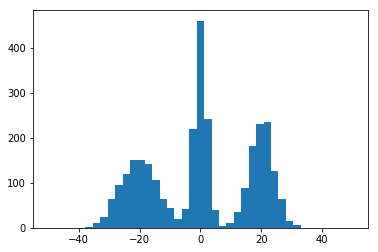

In [28]:
from time import sleep
from numpy import *
from matplotlib.pylab import *
import pypr.clustering.gmm as gmm

x1 = np.random.normal(0, 2, 1000)
x2 = np.random.normal(20, 4, 1000)
x3 = np.random.normal(-20, 6, 1000)
X = np.concatenate((x1,x2,x3),axis=0)
Y = np.array(X)[np.newaxis]
Y = Y.T
hist(X,41, (-50,50))
show()

Aplicamos el algoritmo EM al conjunto de datos anteriores y veremos el resultado del algoritmo para diferentes iteraciones.

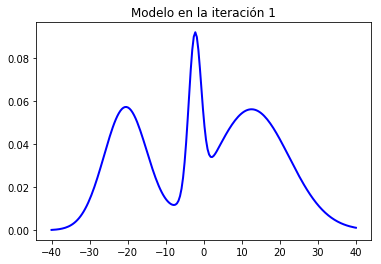

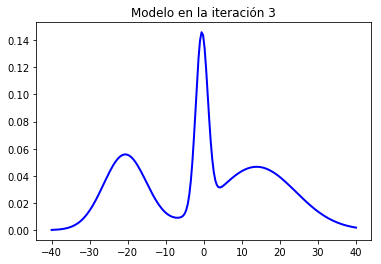

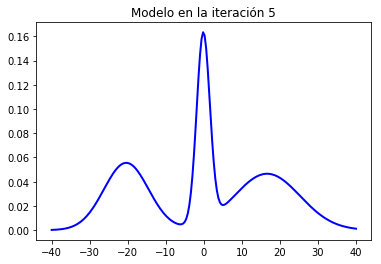

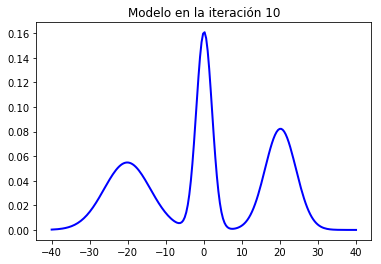

<function matplotlib.pyplot.show>

In [114]:
import pypr.clustering.gmm as gmm
xplt = np.linspace(-40, 40, 200)
x1plt = np.array(xplt).reshape(200,1)
for i in [1,3,5,10]:
    np.random.seed(9)
    cen_lst, cov_lst, p_k, logL = gmm.em_gm(Y, K = 3, max_iter = i,verbose = False, iter_call = None)
    logprob = GaussProb(x1plt,cen_lst,cov_lst,p_k)
    plt.plot(xplt, logprob,'b', linewidth=2)
    plt.title(u'Modelo en la iteración %d' %i)
    plt.pause(0.05)
plt.show

En el próximo ejemplo se generarán una serie de muestras en dos dimensiones, a partir de un modelo GMM para el cual los valores de los parámetros se han ajustado de manera arbitraria. Posteriormente se usael algoritmo EM para a partir del conjunto de puntos generados, estima los valores de los parámetros del modelo. Al final podremos comparar que tanto se asemejan los parámetros encontrados por el algoritmo con respecto a los parámetros reales.

iteration= 0  delta log likelihood= nan
iteration= 1  delta log likelihood= -3943846567794.2017
iteration= 2  delta log likelihood= -17.82534209590085
iteration= 3  delta log likelihood= -6.19836142004533
iteration= 4  delta log likelihood= -3.8202063060475666
iteration= 5  delta log likelihood= -2.8819252416747076
iteration= 6  delta log likelihood= -2.4990504319457614
iteration= 7  delta log likelihood= -2.4251317635666965
iteration= 8  delta log likelihood= -2.5900656406788585
iteration= 9  delta log likelihood= -2.9809297249512383
iteration= 10  delta log likelihood= -3.5582644470023297
iteration= 11  delta log likelihood= -4.214523983294384
iteration= 12  delta log likelihood= -4.829637233904577
iteration= 13  delta log likelihood= -5.412999009576197
iteration= 14  delta log likelihood= -6.125110163256068
iteration= 15  delta log likelihood= -7.189791116923516
iteration= 16  delta log likelihood= -8.881142212086615
iteration= 17  delta log likelihood= -11.619248892446194
iteration

Text(0,0.5,'$x_2$')

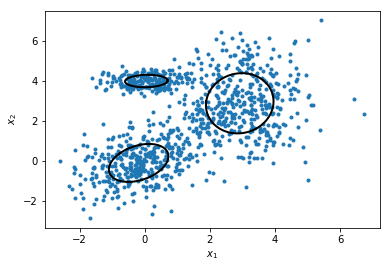

In [115]:
# An example of using the Expectation Maximization (EM) algorithm to find the
# parameters for a mixture of gaussian given a set of samples.

def iter_plot(cen_lst, cov_lst, itr):
    # For plotting EM progress
    if itr % 2 == 0:
        for i in range(len(cen_lst)):
            x,y = gmm.gauss_ellipse_2d(cen_lst[i], cov_lst[i])
            plot(x, y, 'k', linewidth=0.5)
    
seed(1)
mc = [0.4, 0.4, 0.2] # Mixing coefficients
centroids = [ array([0,0]), array([3,3]), array([0,4]) ]
ccov = [ array([[1,0.4],[0.4,1]]), diag((1,2)), diag((0.4,0.1)) ]

# Generate samples from the gaussian mixture model
X = gmm.sample_gaussian_mixture(centroids, ccov, mc, samples=1000)
fig1 = figure()
plot(X[:,0], X[:,1], '.')

# Expectation-Maximization of Mixture of Gaussians
cen_lst, cov_lst, p_k, logL = gmm.em_gm(X, K = 3, max_iter = 50,verbose = True, iter_call = None)
print "Log likelihood (how well the data fits the model) = ", logL
# Plot the cluster ellipses
for i in range(len(cen_lst)):
    x1,x2 = gmm.gauss_ellipse_2d(cen_lst[i], cov_lst[i])
    plot(x1, x2, 'k', linewidth=2)
title(""); xlabel(r'$x_1$'); ylabel(r'$x_2$')

Comparemos los pesos $w$ puestos de manera arbitraria con los pesos hayados por el algoritmo 

In [116]:
print p_k

[0.36671906 0.43559462 0.19768632]


Los centros o medias hayados por el algoritmo

In [117]:
print cen_lst

[array([-0.18824649, -0.10820364]), array([2.9158668 , 2.87641107]), array([0.04877788, 3.99093753])]


Y las matrices de covarianza hayadas por el algoritmo

In [118]:
print cov_lst

[array([[0.83302269, 0.30154804],
       [0.30154804, 0.90097862]]), array([[1.07549529, 0.10135143],
       [0.10135143, 2.27090578]]), array([[0.42740285, 0.01485074],
       [0.01485074, 0.09634444]])]


-------------------------------------------------------------------------------------------------------------------------------

### K-means Clustering

Una tarea muy común en el análisis de datos es el agrupamiento (clustering) de conjuntos de objetos, de tal manera que los objetos queden organizados en subgrupos en los que los elementos son más similares entre ellos que en relación con objetos de otros subgrupos. Este tipo de problemas corresponde al <b>aprendizaje no supervisado</b> y son de gran utilidad en diferentes campos. Si queremos establecer el patrón de comportamiento de un usuario de dispositivo móvil, se puede utilizar la información de GPS y los luagres de mayor interés para el usuario, en un cierto radio de cobertura, quedarán agrupados. 

El algoritmo EM puede ser usado como técnica de agrupamiento porque es en realidad una técnica no supervisada, que agrupa los datos en diferentes subconjuntos representando cada uno por una distribución Gaussiana, sin embargo existen otros métodos alternativos al EM, que pueden ser usados en problemas de agrupamiento (No en clasificación). 

El algoritmo K-means es una popular variante del algoritmo EM, que permite hacer agrupamientos de forma simple. En primer lugar se asume que todos los closters son igualmente probables, es decir $\omega_i = 1/M$, y que la desviación es igual en todos, por consiguiente únicamente se pone enfásis en encontrar las medias de cada cluster, que en este contexto se conocen como <b>centroides</b>. Todos los puntos en un cluster están más cercanos a su centroide que al centroide de cualquier otro cluster. 

Matemáticamente el método consiste en minimizar la siguiente función:

Minimizar $\sum_{k=1}^M \sum_{{\bf{x}}_k \in C_k} \| {\bf{x}}_k - \mu_k\|^2$ Con respecto a $\mu_k$ y $C_k$

Una forma iterativa de resolver el problema se conoce como el algoritmo de Lloyd. El algoritmo consiste en los siguiente:

![alt text](./Images/Lloyd.png "algoritmo k-means")

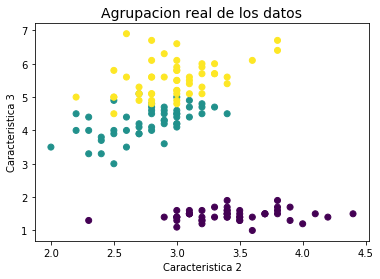

In [84]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data, iris.target
X2 = X[:150][:,1:3]
y2 = y[:150]
plt.title('Agrupacion real de los datos', fontsize=14)
plt.xlabel('Caracteristica 2')
plt.ylabel('Caracteristica 3')
plt.scatter(X2[:,0], X2[:,1], c=y2);

In [82]:
import numpy as np
from sklearn.cluster import KMeans

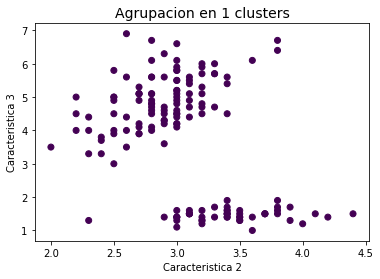

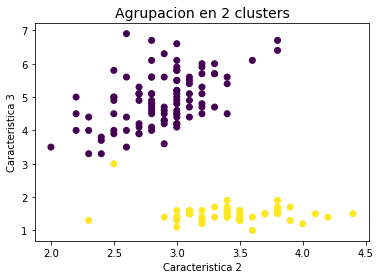

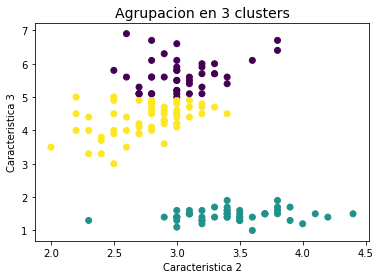

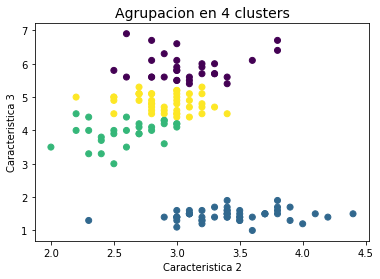

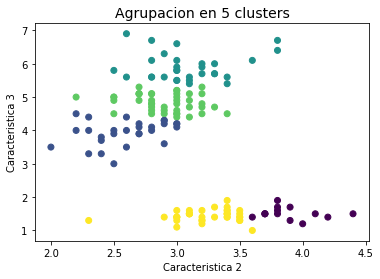

In [85]:
for M in range(1,6):
    kmeans = KMeans(init='k-means++', n_clusters=M, n_init=1)
    kmeans.fit(X2)
    Y2 = kmeans.predict(X2)
    plt.figure()
    plt.title('Agrupacion en %d clusters' % M, fontsize=14)
    plt.xlabel('Caracteristica 2')
    plt.ylabel('Caracteristica 3')
    plt.scatter(X2[:,0], X2[:,1], c=Y2);

Escoger el número de clusters puede ser una tarea complicada cuando no se tiene información a priori sobre el número de grupos existente en los datos. Existen diferentes criterios para seleccionar el número de clusters, pero ninguno de ellos es completamente acertado. Una forma habitual es utilizar una medida conocida como el porcentaje de varianza explicada, el cual se define como el cociente entre la varianza entre grupos sobre total de varianza.

Text(0.5,1,'Elbow for KMeans clustering')

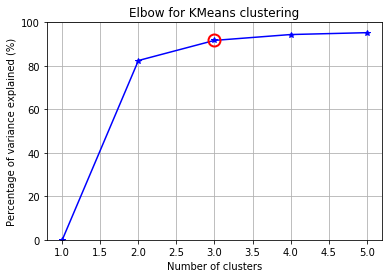

In [91]:
import numpy as np
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from sklearn import datasets
from sklearn.decomposition import RandomizedPCA
from matplotlib import pyplot as plt
from matplotlib import cm

X = X2

##### cluster data into K=1..20 clusters #####
K_MAX = 5
KK = range(1,K_MAX+1)

KM = [kmeans(X,k) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares

##### plots #####
kIdx = 2        # K=10
clr = plt.spectral
mrk = 'os^p<dvh8>+x.'

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, betweenss/totss*100, 'b*-')
ax.plot(KK[kIdx], betweenss[kIdx]/totss*100, marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')

-----------------------------------------------------------------------------------------------------------------------------------------------

### Clustering jerárquico

Los grupos que forman los métodos de clustering vistos hasta el momento son disyuntos, sin embargo existen diversos escenarios en los que los grupos tienen a su vez subgrupos, y estos a su vez subsubgrupos y así sucesivamente. Este tipo de fenómenos son muy comunes cuando se procesan datos de tipo biológico. El clustering jerárquico (En inglés: Hierarchical Clustering), es un método de clustering que permite realizar asociaciones como la descrita anterioremente.

La forma más básica de implementación de clustering hjerárquico es comenzarasignando cada muestra a un cluster independiente, posteriormente eliminar un cluster uniendo las muestras más cercanas entre sí y calculando el centroide del cluster . El procedimiento de unión se sigue realizando hasta que todas las muestras se encuentran reunidas en un solo cluster. 

In [88]:
from scipy.spatial.distance import pdist, squareform
distxy = squareform(pdist(X2, metric='euclidean'))
print distxy

[[0.         0.5        0.31622777 ... 3.83275358 4.0012498  3.73363094]
 [0.5        0.         0.2236068  ... 3.8        4.01995025 3.7       ]
 [0.31622777 0.2236068  0.         ... 3.90512484 4.10487515 3.80525952]
 ...
 [3.83275358 3.8        3.90512484 ... 0.         0.4472136  0.1       ]
 [4.0012498  4.01995025 4.10487515 ... 0.4472136  0.         0.5       ]
 [3.73363094 3.7        3.80525952 ... 0.1        0.5        0.        ]]


/home/julian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


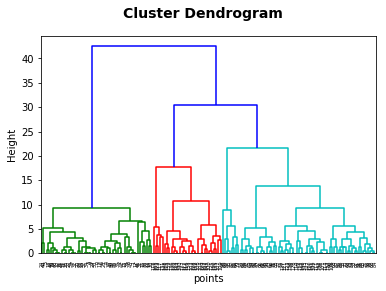

In [89]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(distxy, method='complete')
#print(Z)
R = dendrogram(Z)
xlabel('points')
ylabel('Height')
suptitle('Cluster Dendrogram', fontweight='bold', fontsize=14);

#### Bibliografía